##  Notebook 4 of 5
# Machine Learning Based Unbalance Detection of a Rotating Shaft Using Vibration Data
### Oliver Mey, Willi Neudeck, André Schneider and Olaf Enge-Rosenblatt
##### Fraunhofer IIS/EAS, Fraunhofer Institute for Integrated Circuits, Division Engineering of Adaptive Systems, Dresden, Germany

This Jupyter Notebook is part of a paper submission to the 25th IEEE International Conference on Emerging Technologies and Factory Automation, ETFA 2020. The notebook is the fourth in a series of five freely available notebooks. It contains Python code fragments which were used to get the classifications results described within the ETFA paper.

*Last update: August 04, 2022*

In [1]:
import numpy as np
import pandas as pd
import zipfile
from matplotlib import pyplot as plt
import scipy.stats
import sklearn.ensemble
import sklearn.model_selection
import sklearn.metrics
import sklearn.utils
from joblib import dump, load

## Reading Measurement Data

The entire dataset is freely available via the Fraunhofer Fortadis data space (https://fordatis.fraunhofer.de/handle/fordatis/151.2). Anyone who is interested can checkout this data set and can carry out all the calculations described in the publication for themselves. Since the size of the entire dataset is about 2.7 GB, this notebook offers two options: a) A small subset can be used for a first trial. The ZIP file is part of this Github repository. b) The entire dataset is available via the URL as described below. In total, datasets for 4 different unbalance strengths were recorded (1D/1E ... 4D/4E) as well as one dataset with the unbalance holder without additional weight (i.e. without unbalance, 0D/0E). Each dataset is provided as a csv-file with five columns.

In [2]:
# Option a) local file contains a small subset of the entire dataset
url = '../data/fraunhofer_eas_dataset_for_unbalance_detection_v1.zip'

# Option b) the entire dataset can be directly downloaded via public Fraunhofer Fortadis dataspace
#url = 'https://fordatis.fraunhofer.de/bitstream/fordatis/151.2/1/fraunhofer_eas_dataset_for_unbalance_detection_v1.zip'

# Option c) selected pre-trained models can be found in the directory model/reference
use_reference_models = True
model_path = '../models/reference'
data_path = '../data'

# Option d) all models will be trained again
#use_reference_models = False
#model_path = '../models'
#data_path = '../data'

In [3]:
with zipfile.ZipFile(path, 'r') as f:
    with f.open('0D.csv', 'r') as c:
        data0D = pd.read_csv(c)
    with f.open('0E.csv', 'r') as c:
        data0E = pd.read_csv(c)
    with f.open('1D.csv', 'r') as c:
        data1D = pd.read_csv(c)
    with f.open('1E.csv', 'r') as c:
        data1E = pd.read_csv(c)
    with f.open('2D.csv', 'r') as c:
        data2D = pd.read_csv(c)
    with f.open('2E.csv', 'r') as c:
        data2E = pd.read_csv(c)
    with f.open('3D.csv', 'r') as c:
        data3D = pd.read_csv(c)
    with f.open('3E.csv', 'r') as c:
        data3E = pd.read_csv(c)
    with f.open('4D.csv', 'r') as c:
        data4D = pd.read_csv(c)
    with f.open('4E.csv', 'r') as c:
        data4E = pd.read_csv(c)

At the moment only the first vibration sensor **Vibration_1** is used for the analysis. All four data streams may need to be included in the future.

In [4]:
skip = 50000
window = 4096

In [5]:
def reshape_features(data, column, f):
    features = data[column].values
    features = features[:(len(features)//window)*window]
    features = np.reshape(features, (-1,window), order='C')
    return f(features, axis=1)

def calc_features(url, *files, columns=range(1,4)):
    """
    Method that calculates the minimal set of features. Sensors are selected using the parameter 'columns'
    """
    features = []
    for file in files:
        with url.open(file, 'r') as f:
            data = pd.read_csv(f)
            data = data.iloc[skip:,:]
            data = np.stack(
                [reshape_features(data, 'Measured_RPM', np.mean)]
                + [reshape_features(data, 'Vibration_%d' % i, np.std)
                   for i in columns]
                + [reshape_features(data, 'Vibration_%d' % i, scipy.stats.kurtosis)
                   for i in columns],
                axis=1)
            features.append(data)
    return np.concatenate(features, axis=0)

def get_features2(url, file_good, file_bad):
    with zipfile.ZipFile(url, 'r') as f:
        X_good = calc_features(f, file_good)
        X_bad = calc_features(f, file_bad)
    X = np.concatenate([X_good, X_bad], axis=0)
    y = np.concatenate([np.zeros(X_good.shape[0]), np.ones(X_bad.shape[0])], axis=0)
    return X,y

def get_features1(url, file, columns=range(1,4), label=1):
    with zipfile.ZipFile(url, 'r') as f:
        X = calc_features(f, file, columns=columns)
    y = label * np.ones(X.shape[0])
    return X,y

def get_features(url, group='D', columns=range(1,4)):
    with zipfile.ZipFile(url, 'r') as f:
        good = calc_features(f, '0' + group + '.csv', columns=columns)
        bad1 = calc_features(f, '1' + group + '.csv', columns=columns)
        bad2 = calc_features(f, '2' + group + '.csv', columns=columns)
        bad3 = calc_features(f, '3' + group + '.csv', columns=columns)
        bad4 = calc_features(f, '4' + group + '.csv', columns=columns)
    X = np.concatenate([good, bad1, bad2, bad3, bad4], axis=0)
    length_good = good.shape[0]
    length_bad = bad1.shape[0] + bad2.shape[0] + bad3.shape[0] + bad4.shape[0]
    y = np.concatenate([np.zeros(length_good), np.ones(length_bad)], axis=0)
    return X,y

## Training of a Random Forest Classifier Using a Minimal Set of Features
### Using All 3 Sensors

In [6]:
X_minimal,y_minimal = get_features(path)

In [7]:
X_minimal.shape, y_minimal.shape

((32166, 7), (32166,))

In [8]:
model_minimal = sklearn.model_selection.GridSearchCV(
    sklearn.ensemble.RandomForestClassifier(),
    {'n_estimators': [30, 100, 300],
     'max_depth': [2, 5, 10, 20],
     'min_samples_leaf': [1, 10, 100]},
    scoring='balanced_accuracy')

In [9]:
model_minimal.fit(X_minimal,y_minimal)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 5, 10, 20],
                         'min_samples_leaf': [1, 10, 100],
                         'n_estimators': [30, 100, 300]},
             scoring='balanced_accuracy')

In [10]:
model_minimal.best_score_

0.90221793067914

In [11]:
model_minimal.best_params_

{'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 300}

In [13]:
accuracies_minimal = []
for eval_file in ('0E.csv', '1E.csv', '2E.csv', '3E.csv', '4E.csv'):
    if eval_file == '0E.csv':
        X,y = get_features1(path, eval_file,label=0)
    else:
        X,y = get_features1(path, eval_file,label=1)
    score = sklearn.metrics.accuracy_score(y, model_minimal.predict(X))
    print(eval_file, score)
    accuracies_minimal.append(score)

0E.csv 0.9359281437125748
1E.csv 0.4500896592946802
2E.csv 0.7225883762732175
3E.csv 0.9940191387559809
4E.csv 1.0


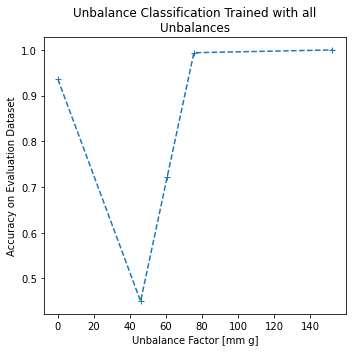

In [14]:
unbalances = np.array([0, 4.59e-5, 6.07e-5,7.55e-5,1.521e-4])
fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot(111, title="Unbalance Classification Trained with all\nUnbalances")
ax1.plot(1e6*unbalances, accuracies_minimal, ls="--", marker="+")
plt.ylabel("Accuracy on Evaluation Dataset")
plt.xlabel("Unbalance Factor [mm g]")
plt.tight_layout()
plt.show()

### Only first sensor a1

In [15]:
X_minimal_a1,y_minimal_a1 = get_features(path, columns=range(1,2))

In [16]:
X_minimal.shape, y_minimal.shape

((32166, 7), (32166,))

In [17]:
model_minimal_a1 = sklearn.model_selection.GridSearchCV(
    sklearn.ensemble.RandomForestClassifier(),
    {'n_estimators': [30, 100, 300],
     'max_depth': [2, 5, 10, 20],
     'min_samples_leaf': [1, 10, 100]},
    scoring='balanced_accuracy')

In [18]:
model_minimal_a1.fit(X_minimal_a1,y_minimal_a1)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 5, 10, 20],
                         'min_samples_leaf': [1, 10, 100],
                         'n_estimators': [30, 100, 300]},
             scoring='balanced_accuracy')

In [19]:
model_minimal_a1.best_score_

0.8248427596196333

In [20]:
model_minimal_a1.best_params_

{'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 300}

In [21]:
accuracies_minimal_a1 = []
for eval_file in ('0E.csv', '1E.csv', '2E.csv', '3E.csv', '4E.csv'):
    if eval_file == '0E.csv':
        X,y = get_features1(path, eval_file, columns=range(1,2), label=0)
    else:
        X,y = get_features1(path, eval_file, columns=range(1,2), label=1)
    score = sklearn.metrics.accuracy_score(y, model_minimal_a1.predict(X))
    print(eval_file, score)
    accuracies_minimal_a1.append(score)

0E.csv 0.8215568862275449
1E.csv 0.5797967722653915
2E.csv 0.7872977831036548
3E.csv 0.6830143540669856
4E.csv 1.0


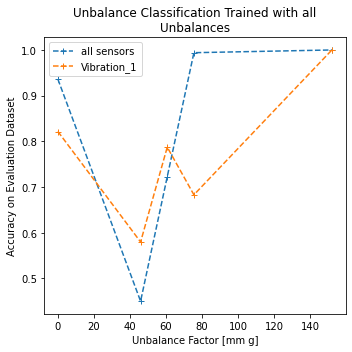

In [22]:
unbalances = np.array([0, 4.59e-5, 6.07e-5,7.55e-5,1.521e-4])
fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot(111, title="Unbalance Classification Trained with all\nUnbalances")
ax1.plot(1e6*unbalances, accuracies_minimal, ls="--", marker="+", label="all sensors")
ax1.plot(1e6*unbalances, accuracies_minimal_a1, ls="--", marker="+", label="Vibration_1")
plt.ylabel("Accuracy on Evaluation Dataset")
plt.xlabel("Unbalance Factor [mm g]")
plt.legend()
plt.tight_layout()
plt.show()

## Training of a Random Forest Classifier Using TSFRESH Features

In [87]:
X_0D = np.load(data_path + "/0D" + "/a1_tsfresh.npy")[:,:,0]
X_1D = np.load(data_path + "/1D" + "/a1_tsfresh.npy")[:,:,0]
X_2D = np.load(data_path + "/2D" + "/a1_tsfresh.npy")[:,:,0]
X_3D = np.load(data_path + "/3D" + "/a1_tsfresh.npy")[:,:,0]
X_4D = np.load(data_path + "/4D" + "/a1_tsfresh.npy")[:,:,0]
X_0E = np.load(data_path + "/0E" + "/a1_tsfresh.npy")[:,:,0]
X_1E = np.load(data_path + "/1E" + "/a1_tsfresh.npy")[:,:,0]
X_2E = np.load(data_path + "/2E" + "/a1_tsfresh.npy")[:,:,0]
X_3E = np.load(data_path + "/3E" + "/a1_tsfresh.npy")[:,:,0]
X_4E = np.load(data_path + "/4E" + "/a1_tsfresh.npy")[:,:,0]

In [88]:
X = np.concatenate([X_0D, X_1D, X_2D, X_3D, X_4D])
y = np.concatenate([np.zeros(X_0D.shape[0]), np.ones(X.shape[0]-X_0D.shape[0])])
X_val = np.concatenate([X_0E, X_1E, X_2E, X_3E, X_4E])
y_val = np.concatenate([np.zeros(X_0E.shape[0]), np.ones(X_val.shape[0]-X_0E.shape[0])])

In [49]:
def train_model(X, y, gridsearch=False):
    if gridsearch:
        model = sklearn.model_selection.GridSearchCV(
            sklearn.ensemble.RandomForestClassifier(),
            {'n_estimators': [30, 100, 300],
             'max_depth': [2, 5, 10, 20],
             'min_samples_leaf': [1, 10, 100]},
            scoring='balanced_accuracy', verbose=100)
        print(model.best_score_)
        print(model.best_params_)
    else:
        model = sklearn.ensemble.RandomForestClassifier(max_depth=20, 
                    min_samples_leaf=1, n_estimators=300)
        model.fit(X, y)
    return model

In [50]:
if not use_reference_models:
    model = train_model(X, y)
    dump(model_tsfresh, f'{model_path}/tsfresh_rfc.joblib') 

0.941619810982175


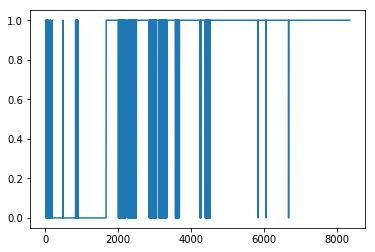

In [99]:
model = load(f'{model_path}/tsfresh_rfc.joblib')
y_predict = model.predict(X_val)
score = sklearn.metrics.accuracy_score(y_val, y_predict)
print(score)
plt.plot(y_predict)

In [92]:
accuracies = []
accuracies.append(sklearn.metrics.accuracy_score(np.zeros(X_0E.shape[0]), model.predict(X_0E)))
accuracies.append(sklearn.metrics.accuracy_score(np.ones(X_1E.shape[0]), model.predict(X_1E)))
accuracies.append(sklearn.metrics.accuracy_score(np.ones(X_2E.shape[0]), model.predict(X_2E)))
accuracies.append(sklearn.metrics.accuracy_score(np.ones(X_3E.shape[0]), model.predict(X_3E)))
accuracies.append(sklearn.metrics.accuracy_score(np.ones(X_4E.shape[0]), model.predict(X_4E)))

In [93]:
print(accuracies)

[0.9652694610778443, 0.8081291093843395, 0.9364889155182744, 0.9982057416267942, 1.0]


### Plotting Classification Accuracies

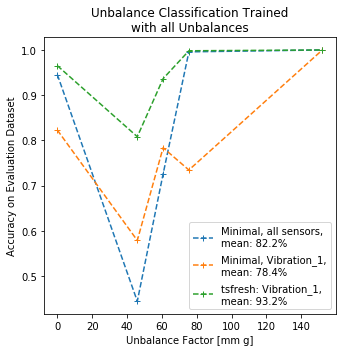

In [94]:
unbalances = np.array([0, 4.59e-5, 6.07e-5,7.55e-5,1.521e-4])
accuracies_minimal = [0.9455089820359281, 0.44411237298266587, 0.725584182144997, 0.9958133971291866, 1.0]
accuracies_minimal_a1 = [0.822754491017964, 0.5786013150029886, 0.7837028160575195, 0.7344497607655502, 1.0]
fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot(111, title="Unbalance Classification Trained\nwith all Unbalances")
ax1.plot(1e6*unbalances, accuracies_minimal, ls="--", marker="+", 
         label="Minimal, all sensors,\nmean: 82.2%")
ax1.plot(1e6*unbalances, accuracies_minimal_a1, ls="--", marker="+", 
         label="Minimal, Vibration_1,\nmean: 78.4%")
ax1.plot(1e6*unbalances, accuracies, ls="--", marker="+", 
         label="tsfresh: Vibration_1,\nmean: 93.2%")
plt.ylabel("Accuracy on Evaluation Dataset")
plt.xlabel("Unbalance Factor [mm g]")
plt.legend(loc="lower right")
plt.tight_layout()
fig.savefig("../figures/Fig.6_h.png", dpi=200)
plt.show()

## Rotation Speed Dependency

In [100]:
model_minimal_a1 = load(f'{model_path}/tsfresh_rfc.joblib')
model_minimal_all = load(f'{model_path}/tsfresh_rfc.joblib')
model_tsfresh = model

In [101]:
X_minimal_a1_eval,y_minimal_a1_eval = get_features(url, group='E', columns=range(1,2))

In [102]:
X_minimal_all_eval,y_minimal_all_eval = get_features(url, group='E')

In [103]:
from scipy.stats import mode

def v2rpm(v):
    return 212*v + 209

# 3s ramp up
fade_in = np.arange(0.0, 4.0, 4.0/(3*4096))
# complete voltage sweep
measurement_circle = np.repeat(np.arange(4.0, 8.2, 0.1), 4096*20.0)
# measurement: start-up + 2 voltage sweeps
measurement = np.concatenate([fade_in, np.tile(measurement_circle,3)]) 
# select the data as actually used
measurement1 = measurement[50000:]
measurement1 = measurement1[:int(len(measurement1)/4096)*4096].reshape(-1,4096)
voltages_measurement = mode(measurement1, axis=1)[0]
voltages_used = np.concatenate([voltages_measurement[:len(X_0E)],
                                voltages_measurement[:len(X_1E)],
                                voltages_measurement[:len(X_2E)],
                                voltages_measurement[:len(X_3E)],
                                voltages_measurement[:len(X_4E)]])
rpms_used = v2rpm(voltages_used)

In [ ]:
rpm_borders = np.arange(1050, 1975, 25)
errors_per_rpm_range_minimal_a1 = []
errors_per_rpm_range_minimal_all = []
errors_per_rpm_range_tsfresh_a1 = []
for i in range(len(rpm_borders)-1):
    eval_inds = np.where((rpms_used>rpm_borders[i])&(rpms_used<rpm_borders[i+1]))[0]
    errors_per_rpm_range_minimal_a1.append(
        1-np.mean(np.abs(np.int32(model_minimal_a1.predict(X_minimal_a1_eval[eval_inds])>0.5).reshape(-1)-y_minimal_a1_eval[eval_inds])))
    errors_per_rpm_range_minimal_all.append(
        1-np.mean(np.abs(np.int32(model_minimal_all.predict(X_minimal_all_eval[eval_inds])>0.5).reshape(-1)-y_minimal_all_eval[eval_inds])))
    errors_per_rpm_range_tsfresh_a1.append(
        1-np.mean(np.abs(np.int32(model_tsfresh.predict(X_eval[eval_inds,:,0])>0.5).reshape(-1)-y_eval[eval_inds])))

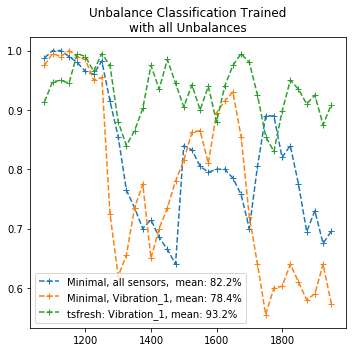

In [119]:
fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot(111, title="Unbalance Classification Trained\nwith all Unbalances")
plt.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range_minimal_all, marker="+", ls="--",
         label="Minimal, all sensors,  mean: 82.2%")
plt.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range_minimal_a1, marker="+", ls="--",
         label="Minimal, Vibration_1, mean: 78.4%")
plt.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range_tsfresh_a1, marker="+", ls="--",
         label="tsfresh: Vibration_1, mean: 93.2%")
plt.legend()
plt.tight_layout()
plt.show()

## Training of a Neural Network Using TSFRESH Features

In [12]:
from sklearn.model_selection import train_test_split
train_test_ratio = 0.9
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 1-train_test_ratio, random_state = 0)

In [15]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler(quantile_range=(5,95)).fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)
X_val_sc = scaler.transform(X_val)

In [84]:
from tensorflow.keras.layers import LeakyReLU,Dense,Input,Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

if not use_reference_models:
    weight_for_0 = len(y_train)/(2*len(y_train[y_train==0]))
    weight_for_1 = len(y_train)/(2*len(y_train[y_train==1]))
    class_weight = {0: weight_for_0, 1: weight_for_1}

    n_layers=2
    dropout_rate = 0.4

    X_in = Input(shape=(X_train_sc.shape[1],))
    x = X_in
    for j in range(n_layers):
        x = Dropout(rate=dropout_rate)(x)
        x = Dense(units = 1024, activation="linear")(x)
        x = LeakyReLU(alpha=0.05)(x)
    X_out = Dense(units = 1, activation = 'sigmoid')(x)
    model = Model(X_in, X_out)

    best_model_filepath = f'{model_path}/tsfresh_nn.h5'
    checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_loss', verbose=1, 
                                 save_best_only=True, mode='min')
    model.compile(optimizer = Adam(lr=0.0005), loss = 'binary_crossentropy', 
                  metrics = ['accuracy'])
    model.summary()

    model.fit(X_train_sc, y_train, epochs = 100, batch_size = 128,
              validation_data=(X_test_sc, y_test), callbacks=[checkpoint], 
              class_weight=class_weight)

In [85]:
best_model_filepath = f'{model_path}/tsfresh_nn.h5'
model = load_model(best_model_filepath)

In [89]:
model.evaluate(X_val_sc, y_val)

8359/8359 [==============================] - 1s 89us/sample - loss: 0.9649 - accuracy: 0.8158


[0.9648595222610724, 0.8157674]

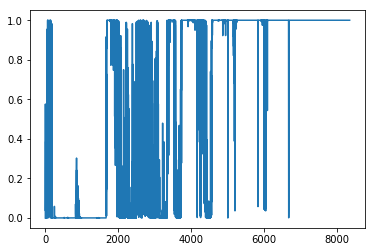

In [90]:
plt.plot(model.predict(X_val_sc))

--> NN classifies worse than Random Forest

## Pairwise Classification

In [24]:
X_a1 = []
y_a1 = []
X_a1_val = []
y_a1_val = []
for file in ('0D.csv', '1D.csv', '2D.csv', '3D.csv', '4D.csv'):
    if file == '0D.csv':
        X_,y_ = get_features1(path, file, columns=range(1,2), label=0)
    else:
        X_,y_ = get_features1(path, file, columns=range(1,2), label=1)
    X_a1.append(X_)
    y_a1.append(y_)
        
for file in ('0E.csv', '1E.csv', '2E.csv', '3E.csv', '4E.csv'):
    if file == '0E.csv':
        X_,y_ = get_features1(path, file, columns=range(1,2), label=0)
    else:
        X_,y_ = get_features1(path, file, columns=range(1,2), label=1)
    X_a1_val.append(X_)
    y_a1_val.append(y_)    

In [26]:
X = []
y = []
X_val = []
y_val = []
for file in ('0D.csv', '1D.csv', '2D.csv', '3D.csv', '4D.csv'):
    if file == '0D.csv':
        X_,y_ = get_features1(path, file, label=0)
    else:
        X_,y_ = get_features1(path, file, label=1)
    X.append(X_)
    y.append(y_)
        
for file in ('0E.csv', '1E.csv', '2E.csv', '3E.csv', '4E.csv'):
    if file == '0E.csv':
        X_,y_ = get_features1(path, file,label=0)
    else:
        X_,y_ = get_features1(path, file,label=1)
    X_val.append(X_)
    y_val.append(y_) 

In [70]:
X_tsfresh = [X_0D, X_1D, X_2D, X_3D, X_4D]
X_tsfresh_val = [X_0E, X_1E, X_2E, X_3E, X_4E]
y_tsfresh = [np.zeros(X_0D.shape[0]), np.ones(X_1D.shape[0]), np.ones(X_2D.shape[0]),
                 np.ones(X_3D.shape[0]), np.ones(X_4D.shape[0])]
y_tsfresh_val = [np.zeros(X_0E.shape[0]), np.ones(X_1E.shape[0]), np.ones(X_2E.shape[0]),
                  np.ones(X_3E.shape[0]), np.ones(X_4E.shape[0])]

In [78]:
if not use_reference_models:
    best_params_minimal_a1 = []
    best_params_minimal_all = []
    best_params_tsfresh = []

    for i in range(4):
        X_a1_i = np.concatenate([X_a1[0], X_a1[i+1]])
        y_a1_i = np.concatenate([y_a1[0], y_a1[i+1]])
        X_a1_val_i = np.concatenate([X_a1_val[0], X_a1_val[i+1]])
        y_a1_val_i = np.concatenate([y_a1_val[0], y_a1_val[i+1]])

        X_i = np.concatenate([X[0], X[i+1]])
        y_i = np.concatenate([y[0], y[i+1]])
        X_val_i = np.concatenate([X_val[0], X_val[i+1]])
        y_val_i = np.concatenate([y_val[0], y_val[i+1]])

        X_tsfresh_i = np.concatenate([X_tsfresh[0], X_tsfresh[i+1]])
        y_tsfresh_i = np.concatenate([y_tsfresh[0], y_tsfresh[i+1]])
        X_tsfresh_val_i = np.concatenate([X_tsfresh_val[0], X_tsfresh_val[i+1]])
        y_tsfresh_val_i = np.concatenate([y_tsfresh_val[0], y_tsfresh_val[i+1]])

        model_rfc_a1 = sklearn.model_selection.GridSearchCV(
            sklearn.ensemble.RandomForestClassifier(),
            {'n_estimators': [30, 100, 300],
             'max_depth': [10, 20],
             'min_samples_leaf': [1]},
            scoring='balanced_accuracy', verbose=100)

        model_rfc = sklearn.model_selection.GridSearchCV(
            sklearn.ensemble.RandomForestClassifier(),
            {'n_estimators': [30, 100, 300],
             'max_depth': [10, 20],
             'min_samples_leaf': [1]},
            scoring='balanced_accuracy', verbose=100)

        model_tsfresh_rfc = sklearn.model_selection.GridSearchCV(
            sklearn.ensemble.RandomForestClassifier(),
            {'n_estimators': [30, 100, 300],
             'max_depth': [10, 20],
             'min_samples_leaf': [1]},
            scoring='balanced_accuracy', verbose=100)

        model_rfc_a1.fit(X_a1_i,y_a1_i)
        print(model_rfc_a1.best_score_)
        print(model_rfc_a1.best_params_)
        best_params_minimal_a1.append(model_rfc_a1.best_params_)
        print("Evaluation: " + str(sklearn.metrics.accuracy_score(y_a1_val_i, model_rfc_a1.predict(X_a1_val_i))))
        dump(model_rfc_a1, f'{model_path}/model_rfc_a1_pair_{i}.joblib') 
        model_rfc.fit(X_i,y_i)
        print(model_rfc.best_score_)
        print(model_rfc.best_params_)
        best_params_minimal_all.append(model_rfc.best_params_)
        print("Evaluation: " + str(sklearn.metrics.accuracy_score(y_val_i, model_rfc.predict(X_val_i))))
        dump(model_rfc, f'{model_path}/model_rfc_pair_{i}.joblib') 
        model_tsfresh_rfc.fit(X_tsfresh_i,y_tsfresh_i)
        print(model_tsfresh_rfc.best_score_)
        print(model_tsfresh_rfc.best_params_)
        best_params_tsfresh.append(model_tsfresh_rfc.best_params_)
        print("Evaluation: " + str(sklearn.metrics.accuracy_score(y_tsfresh_val_i, model_tsfresh_rfc.predict(X_tsfresh_val_i))))
        dump(model_tsfresh_rfc, f'{model_path}/model_tsfresh_rfc_pair_{i}.joblib')

    print(best_params_minimal_a1)
    print(best_params_minimal_all)
    print(best_params_tsfresh)

In [80]:
accuracies_ts_features = []
for i in range(4):
    model_rfc_a1 = load(f'{model_path}/model_rfc_a1_pair_{i}.joblib') 
    model_rfc = load(f'{model_path}/model_rfc_pair_{i}.joblib')
    model_tsfresh_rfc = load(f'{model_path}/model_tsfresh_rfc_pair_{i}.joblib') 
    
    X_a1_val_ = np.concatenate([X_a1_val[0], X_a1_val[i+1]])
    y_a1_val_ = np.concatenate([y_a1_val[0], y_a1_val[i+1]])
    
    X_val_ = np.concatenate([X_val[0], X_val[i+1]])
    y_val_ = np.concatenate([y_val[0], y_val[i+1]])
    
    X_tsfresh_val_ = np.concatenate([X_tsfresh_val[0], X_tsfresh_val[i+1]])
    y_tsfresh_val_ = np.concatenate([y_tsfresh_val[0], y_tsfresh_val[i+1]])
    
    acc_rfc_a1 = sklearn.metrics.accuracy_score(y_a1_val_, model_rfc_a1.predict(X_a1_val_))
    acc_rfc = sklearn.metrics.accuracy_score(y_val_, model_rfc.predict(X_val_))
    acc_tsfresh_rfc = sklearn.metrics.accuracy_score(y_tsfresh_val_, model_tsfresh_rfc.predict(X_tsfresh_val_))
    accuracies_ts_features.append([acc_rfc_a1, acc_rfc, acc_tsfresh_rfc])
accuracies_ts_features = np.array(accuracies_ts_features)

In [81]:
accuracies_ts_features

array([[0.65599761, 0.62488783, 0.58719713],
       [0.6262354 , 0.63012878, 0.66007787],
       [0.70137642, 0.88779174, 0.9700778 ],
       [0.99880419, 0.99880419, 1.        ]])

In [82]:
np.mean(accuracies_ts_features, axis=0)

array([0.7456034 , 0.78540313, 0.8043382 ])

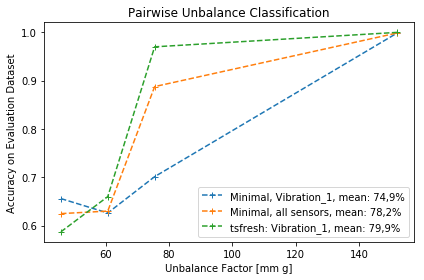

In [83]:
fig=plt.figure()
ax1=plt.subplot(111, title = "Pairwise Unbalance Classification")
unbalances = np.array([0, 4.59e-5, 6.07e-5,7.55e-5,1.521e-4])
ax1.plot(1e6*unbalances[1:], accuracies_ts_features[:,0], 
         label="Minimal, Vibration_1, mean: 74,9%", marker="+", ls="--")
ax1.plot(1e6*unbalances[1:], accuracies_ts_features[:,1], 
         label="Minimal, all sensors, mean: 78,2%", marker="+", ls="--")
ax1.plot(1e6*unbalances[1:], accuracies_ts_features[:,2], 
         label="tsfresh: Vibration_1, mean: 79,9%", marker="+", ls="--")
plt.ylabel("Accuracy on Evaluation Dataset")
plt.xlabel("Unbalance Factor [mm g]")
plt.legend()
plt.tight_layout()
plt.show()